## Private 2위
gbr과 mlp 앙상블을 사용했고, 아래 두 가지 핵심 아이디어를 실행했다.

1. 이상치 제거
    - income_status column을 활용한 이상치 제거. income_status의 범주 별 income 분호를 확인해보니 unknown과 under median 범주의 income 평균이 비슷하여 unknown 데터를 under median으로 바꿨고, income_status = under median/over median인 데이터를 나눠 IQR 기반으로 이상치 제거 실행

2. gbr + mlp 앙상블

In [1]:
name = "final_check_1"

In [2]:
gbr_learning_rate = 0.05
gbr_n_estimators = 600
gbr_max_depth = 4
gbr_min_samples_split = 16  # 노드 분할을 위한 최소 샘플 수
gbr_min_samples_leaf = 16  # 리프노드 최소 샘플 수

In [3]:
mlp_activation = "tanh"
mlp_hidden_layer_size = (100,)
mlp_learning_rate_init = 0.001
mlp_alpha = 1e-6
mlp_learning_rate = "constant"
mlp_max_iter = 500

In [4]:
import os
import random
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

In [5]:
import warnings

warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)  # seed 고정

In [8]:
train = pd.read_csv("./Data/train (2).csv")
test = pd.read_csv("./Data/test.csv")

In [9]:
train.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

### 중복행 확인 및 처리

In [10]:
features = [i for i in list(train.columns) if i not in ["Income", "ID"]]
features

['Age',
 'Gender',
 'Education_Status',
 'Employment_Status',
 'Working_Week (Yearly)',
 'Industry_Status',
 'Occupation_Status',
 'Race',
 'Hispanic_Origin',
 'Martial_Status',
 'Household_Status',
 'Household_Summary',
 'Citizenship',
 'Birth_Country',
 'Birth_Country (Father)',
 'Birth_Country (Mother)',
 'Tax_Status',
 'Gains',
 'Losses',
 'Dividends',
 'Income_Status']

In [11]:
drop_dup1 = train.drop_duplicates(features)
len(drop_dup1)

18320

In [12]:
features = [i for i in list(train.columns) if i not in ["ID"]]
features

['Age',
 'Gender',
 'Education_Status',
 'Employment_Status',
 'Working_Week (Yearly)',
 'Industry_Status',
 'Occupation_Status',
 'Race',
 'Hispanic_Origin',
 'Martial_Status',
 'Household_Status',
 'Household_Summary',
 'Citizenship',
 'Birth_Country',
 'Birth_Country (Father)',
 'Birth_Country (Mother)',
 'Tax_Status',
 'Gains',
 'Losses',
 'Dividends',
 'Income_Status',
 'Income']

In [13]:
drop_dup2 = train.drop_duplicates(features)
len(drop_dup2)

18501

In [14]:
# 중복값 제거
train.drop_duplicates(features, inplace=True)
train.reset_index(drop=True, inplace=True)


In [15]:
train.shape

(18501, 23)

### Simple EDA

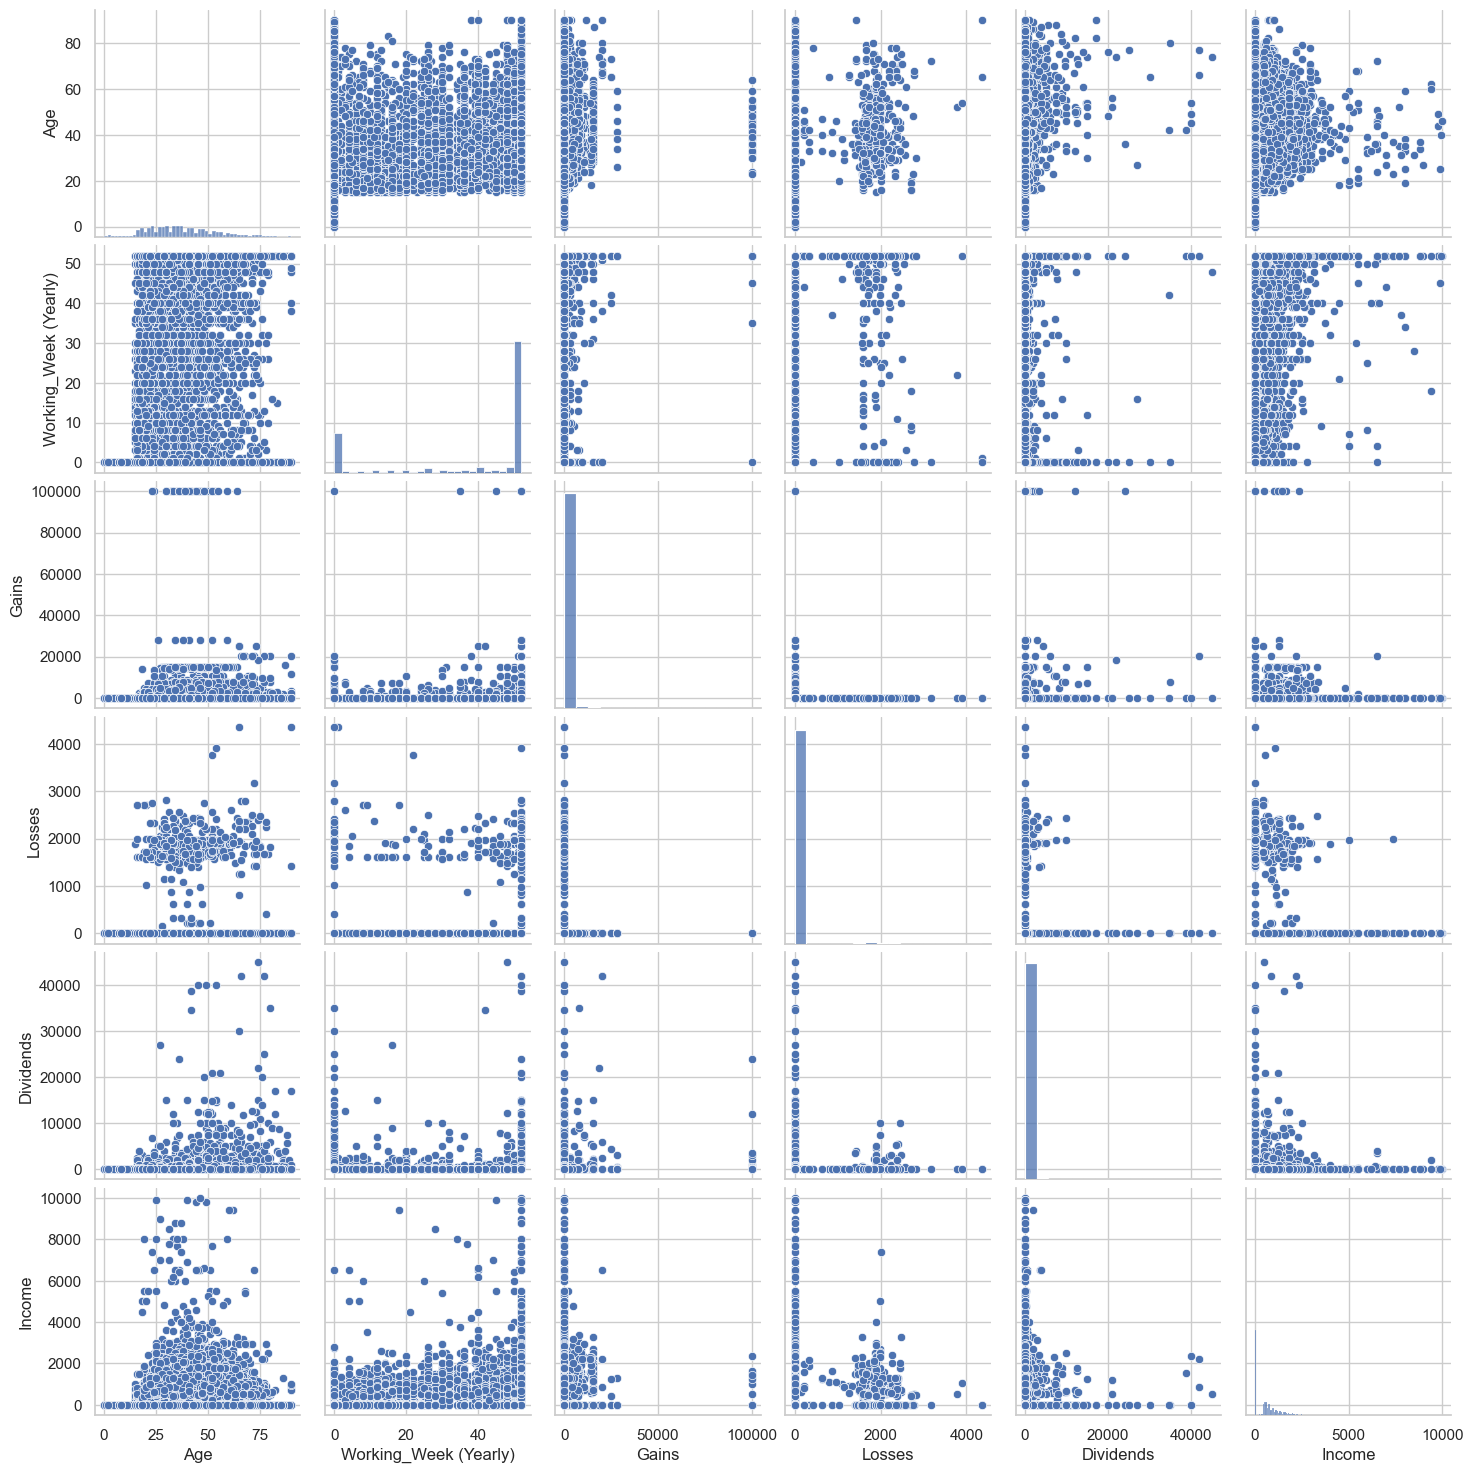

In [16]:
sns.set_theme(style="whitegrid")
sns.pairplot(train)
plt.show()

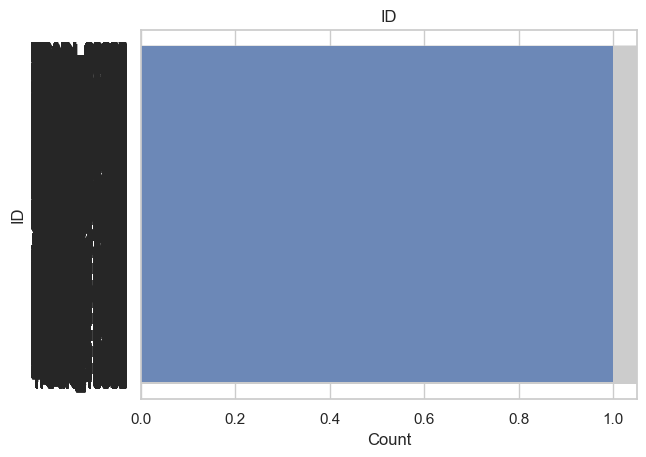

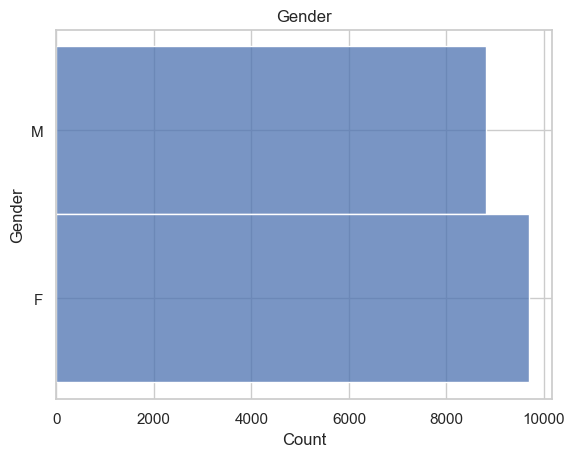

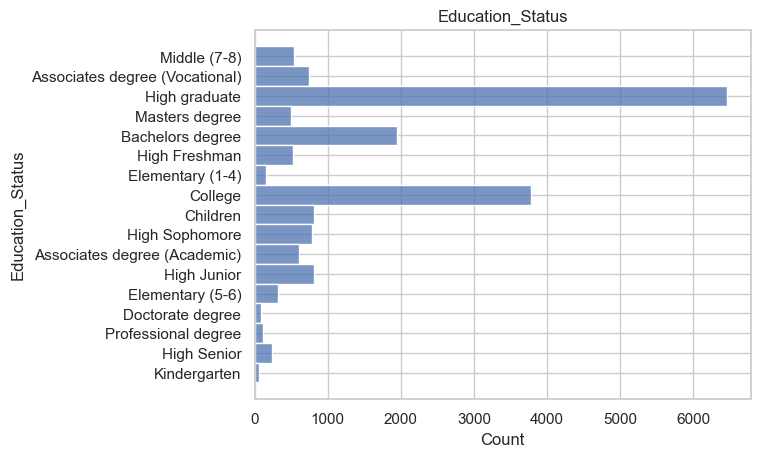

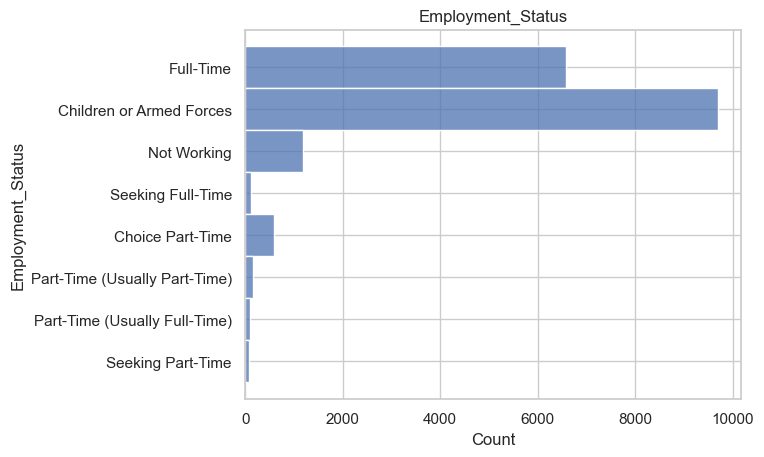

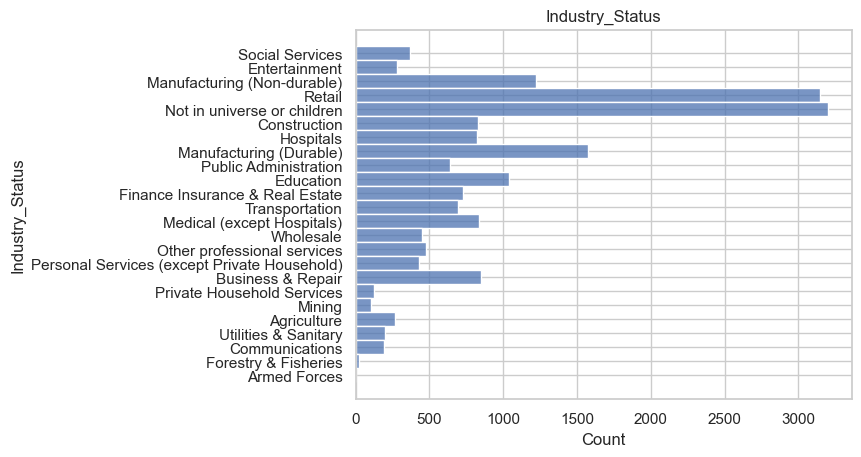

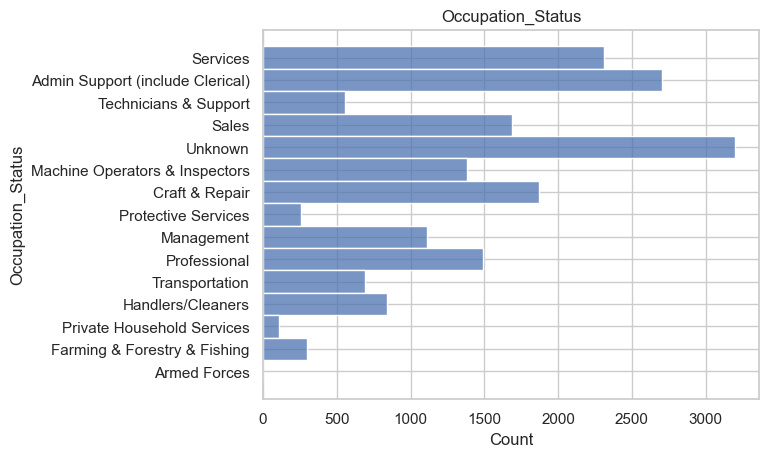

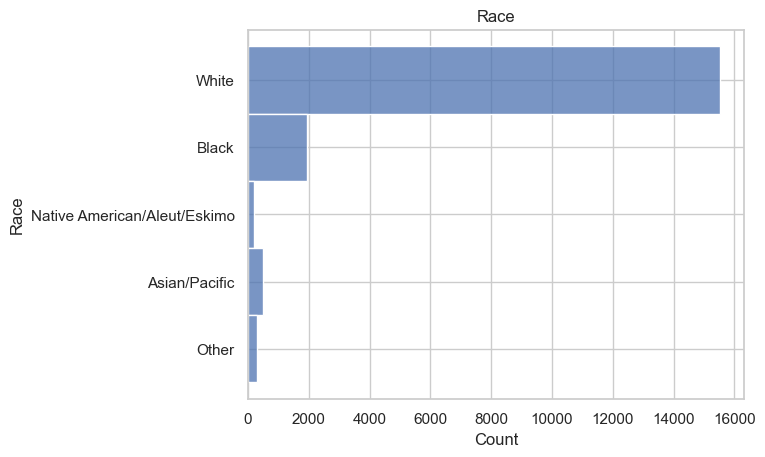

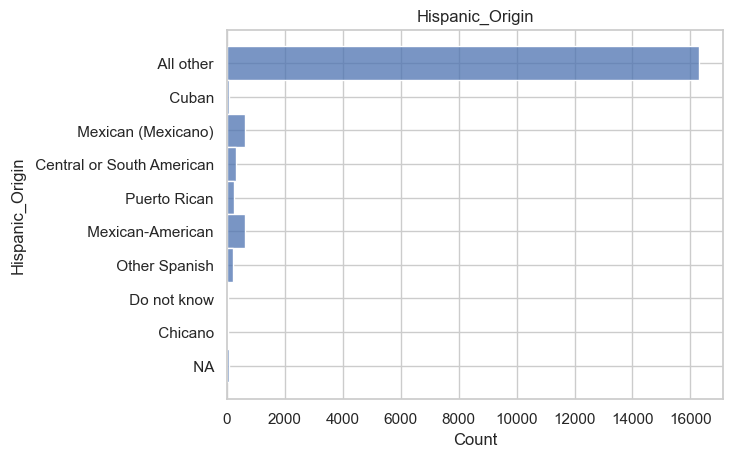

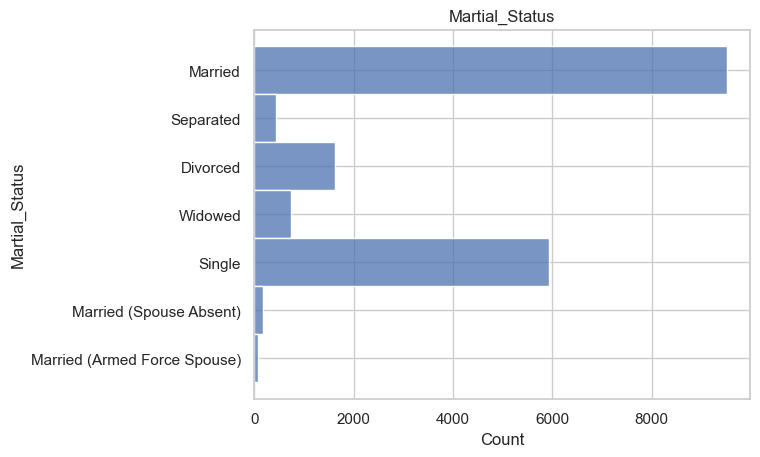

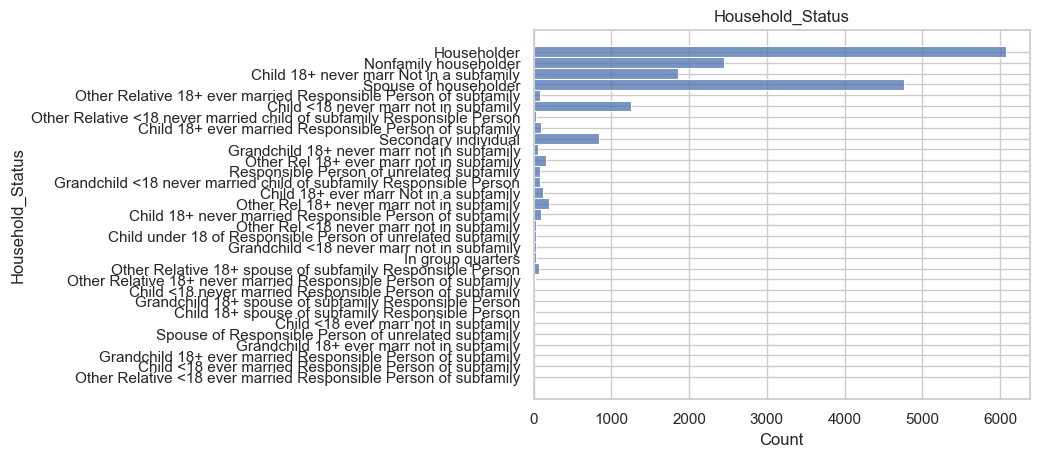

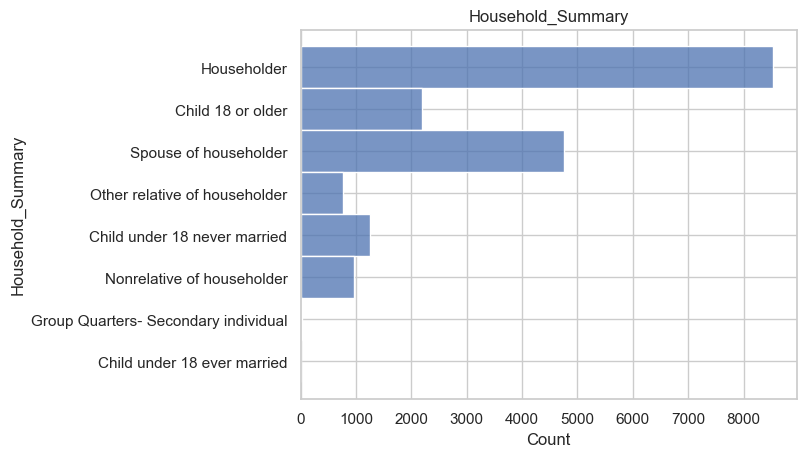

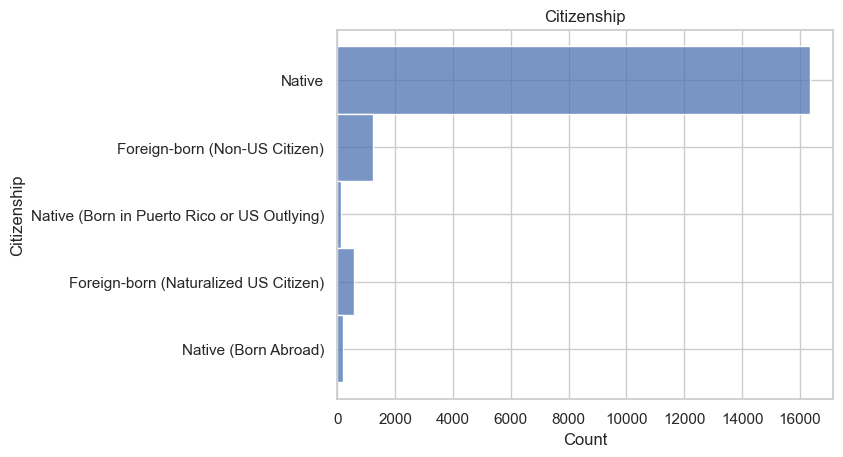

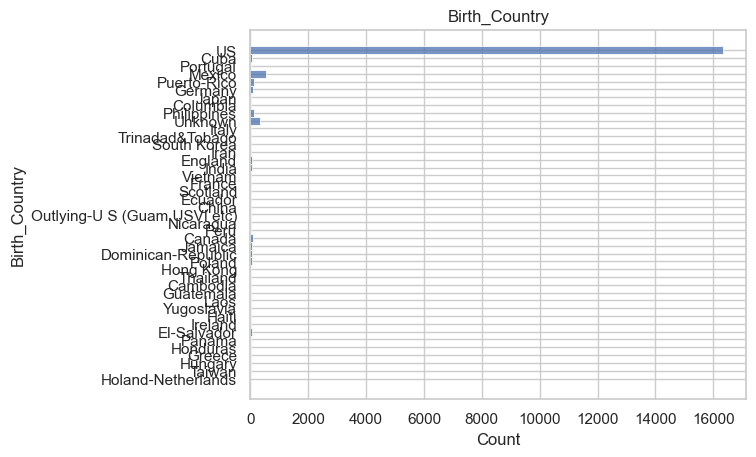

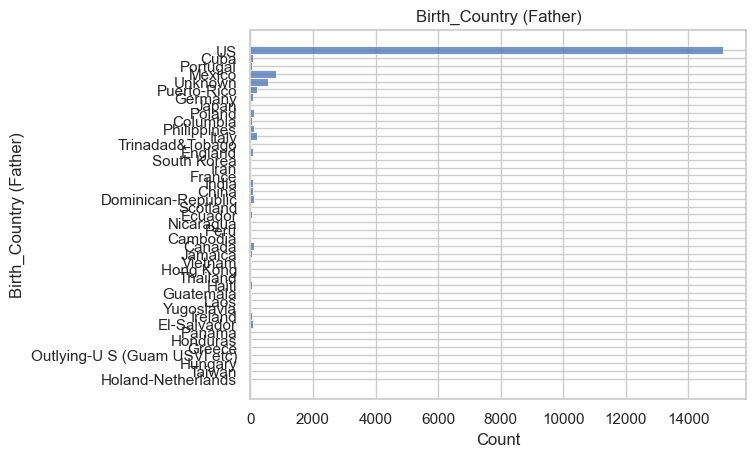

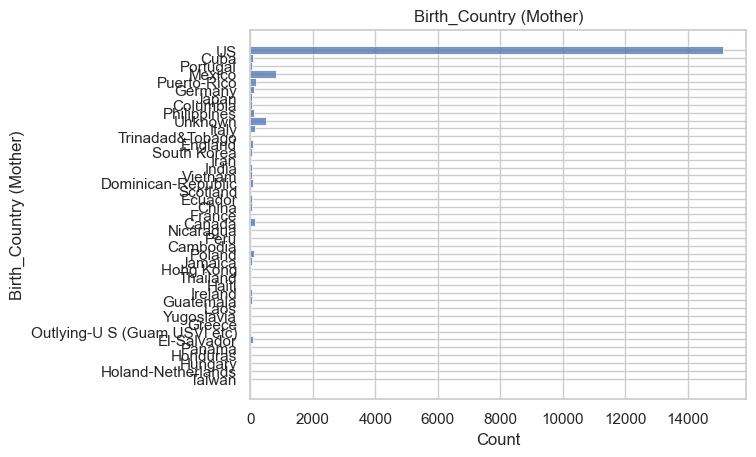

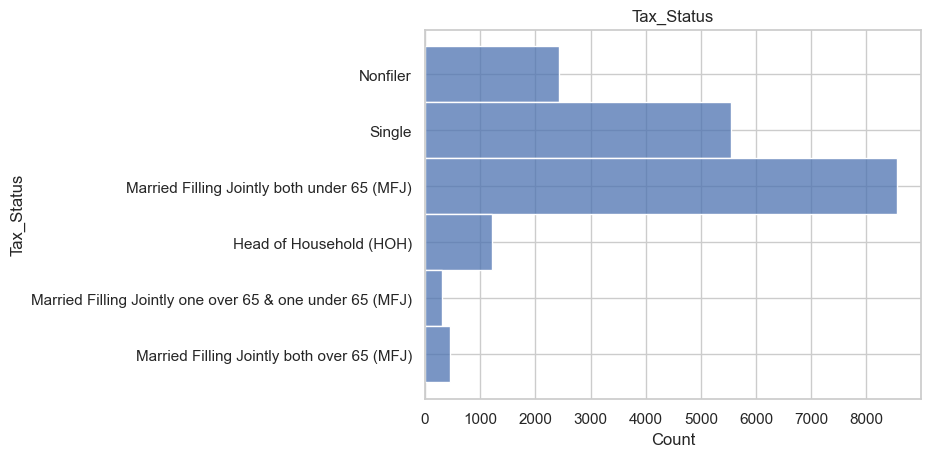

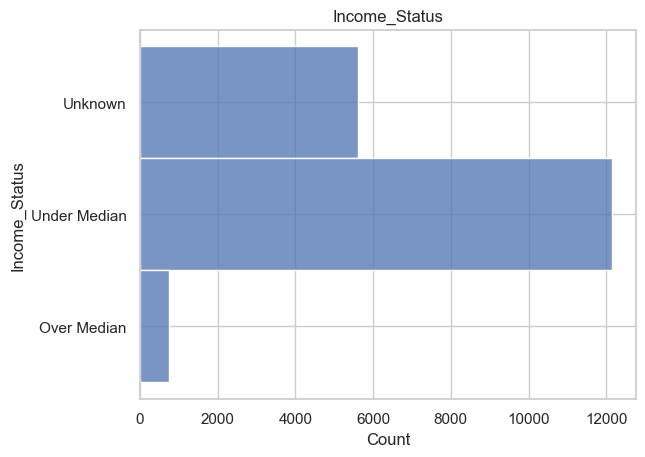

In [17]:
# categorical column 확인
cat_cols = list(train.select_dtypes(include="object").columns)
for column in cat_cols:
    plt.title(column)
    sns.histplot(y=train[column])
    plt.show()

### Feature engineering
- drop : Hispanic Origin, Household status, Birth Country, Birth Country(Mother), Birth Country(Father), education_status
- outlier 제거 : Gain, Losses, Dividends

In [18]:
train["Education_Status"].unique()

array(['Middle (7-8)', 'Associates degree (Vocational)', 'High graduate',
       'Masters degree', 'Bachelors degree', 'High Freshman',
       'Elementary (1-4)', 'College', 'Children', 'High Sophomore',
       'Associates degree (Academic)', 'High Junior', 'Elementary (5-6)',
       'Doctorate degree', 'Professional degree', 'High Senior',
       'Kindergarten'], dtype=object)

In [19]:
# education status 범주 변경
def modify_education(education):
    if education in ['Children', 'Kindergarten', 'Elementary (1-4)', 'Elementary (5-6)', 
                     'Middle (7-8)', 'High Freshman', 'High Sophomore', 
                     'High Junior', 'High Senior']:
        return 'dropout'
    elif education in ['College', 'Associates degree (Academic)', 'Associates degree (Vocational)']:
        return 'CommunityCollege'
    elif education in ['Professional degree', 'Masters degree']:
        return 'Masters degree'
    else:
        return education

In [20]:
train["Education"] = train["Education_Status"]
train["Education"] = train["Education"].apply(modify_education)

In [21]:
test["Education"] = test["Education_Status"]
test["Education"] = test["Education"].apply(modify_education)

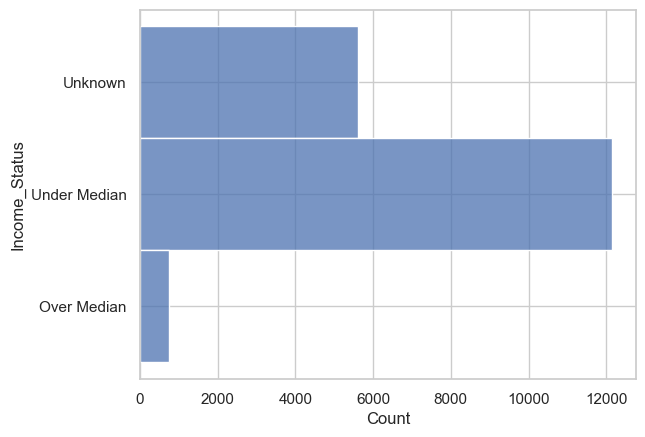

In [22]:
# Income status 변경사항
sns.histplot(y="Income_Status", data=train)
plt.show()

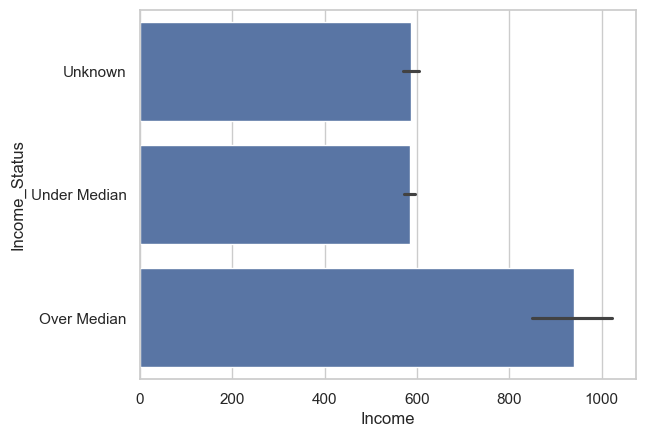

In [23]:
sns.barplot(y="Income_Status", data=train, x="Income", orient="h")
plt.show()

대부분이 unknown 또는 under median

unknown과 under median 범주의 income 평균이 비슷함

unknown 데이터를 under median으로 대체

In [24]:
def modify_income_status(status):
    if status in ["Unknown", "Under Median"]:
        return "Under Median"
    else:
        return status

In [25]:
train["Income_Status"] = train["Income_Status"].apply(modify_income_status)
test["Income_Status"] = test["Income_Status"].apply(modify_income_status)

### 이상치 제거
under median 범주와 over median 범주 내에서 outlier제거

In [26]:
under = train.loc[train["Income_Status"]=="Under Median"]
Q1 = np.quantile(under['Income'], 0.25)
Q3 = np.quantile(under['Income'], 0.75)
IQR = Q3 - Q1
outlier_step = IQR*1.5

u_outliers = under.loc[(under["Income"] < Q1-outlier_step) | (under['Income'] > Q3 + outlier_step)]
len(u_outliers)

233

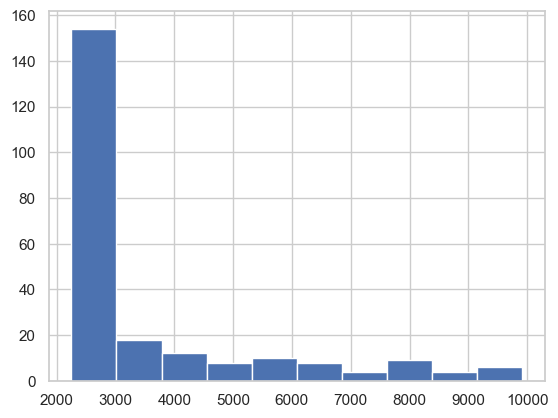

In [27]:
plt.hist(u_outliers["Income"])
plt.show()

In [28]:
over = train.loc[train['Income_Status']=="Over Median"]

Q1 = np.quantile(over["Income"], 0.25)
Q3 = np.quantile(over["Income"], 0.75)
IQR = Q3 - Q1
outlier_step = IQR*1.5

o_outliers = over.loc[(over["Income"] < Q1 - outlier_step)|(over["Income"] > Q3 + outlier_step)]
len(o_outliers)

7

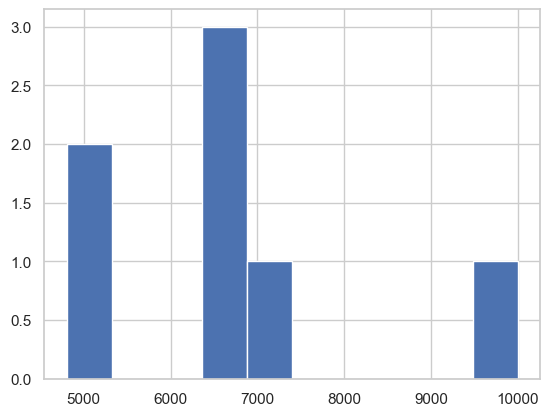

In [29]:
plt.hist(o_outliers["Income"])
plt.show()

outlier 제거 전후 데이터 비교

In [30]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Age,18501.000000,37.752284,16.726767,0.000000,25.000000,36.000000,48.000000,90.000000
Working_Week (Yearly),18501.000000,37.739095,20.720317,0.000000,24.000000,52.000000,52.000000,52.000000
Gains,18501.000000,414.171666,4307.383394,0.000000,0.000000,0.000000,0.000000,99999.000000
Losses,18501.000000,43.459435,290.029113,0.000000,0.000000,0.000000,0.000000,4356.000000
Dividends,18501.000000,133.453813,1254.362886,0.000000,0.000000,0.000000,0.000000,45000.000000
Income,18501.000000,599.213880,710.776048,0.000000,0.000000,505.000000,900.000000,9999.000000


In [31]:
outliers = list(u_outliers.index) + list(o_outliers.index)

In [32]:
train.drop(index=outliers, inplace=True)
train.reset_index(drop=True, inplace=True)

In [33]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Age,18261.000000,37.695197,16.777925,0.000000,25.000000,36.000000,48.000000,90.000000
Working_Week (Yearly),18261.000000,37.624719,20.789454,0.000000,22.000000,52.000000,52.000000,52.000000
Gains,18261.000000,409.006736,4322.878716,0.000000,0.000000,0.000000,0.000000,99999.000000
Losses,18261.000000,42.980943,288.539126,0.000000,0.000000,0.000000,0.000000,4356.000000
Dividends,18261.000000,133.059800,1261.052719,0.000000,0.000000,0.000000,0.000000,45000.000000
Income,18261.000000,558.343683,575.949926,0.000000,0.000000,500.000000,900.000000,4000.000000


### gain, losses, dividends 이진화
값이 0보다 크면 1, 아니면 0으로 처리

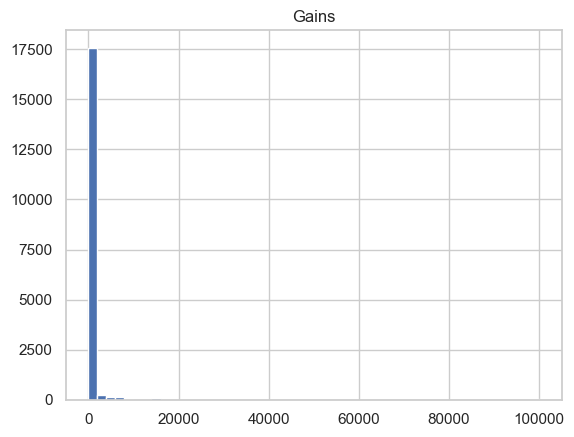

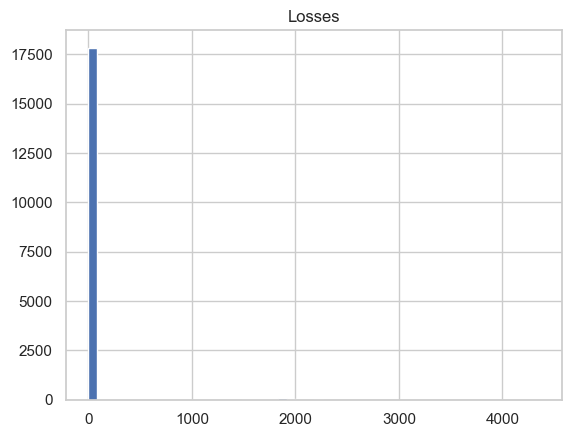

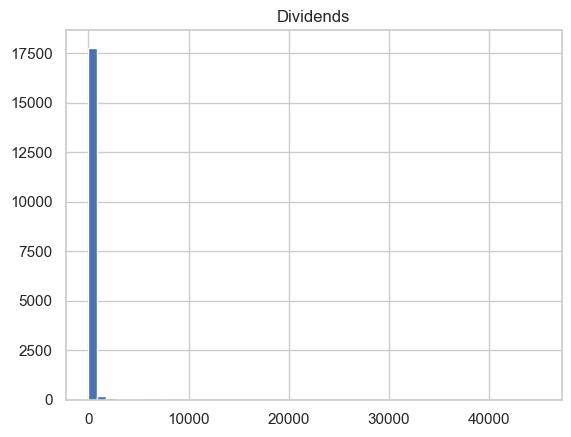

In [34]:
cols = ["Gains", "Losses", "Dividends"]
for column in cols:
    plt.title(column)
    plt.hist(train[column], bins=50)
    plt.show()

In [35]:
# train["Gains"] = train["Gains"].apply(lambda x : 1 if x > 0 else 0)
# train["Losses"] = train["Losses"].apply(lambda x : 1 if x > 0 else 0)
# train["Dividends"] = train["Dividends"].apply(lambda x : 1 if x > 0 else 0)

# test["Gains"] = test["Gains"].apply(lambda x : 1 if x > 0 else 0)
# test["Losses"] = test["Losses"].apply(lambda x : 1 if x > 0 else 0)
# test["Dividends"] = test["Dividends"].apply(lambda x : 1 if x > 0 else 0)

train['Gains'] = np.where(train['Gains']>0, 1, 0)
test['Gains'] = np.where(test['Gains']>0, 1, 0)

train['Losses'] = np.where(train['Losses']>0, 1, 0)
test['Losses'] = np.where(test['Losses']>0, 1, 0)

train['Dividends'] = np.where(train['Dividends']>0, 1, 0)
test['Dividends'] = np.where(test['Dividends']>0, 1, 0)

In [36]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Age,18261.000000,37.695197,16.777925,0.000000,25.000000,36.000000,48.000000,90.000000
Working_Week (Yearly),18261.000000,37.624719,20.789454,0.000000,22.000000,52.000000,52.000000,52.000000
Gains,18261.000000,0.041564,0.199596,0.000000,0.000000,0.000000,0.000000,1.000000
Losses,18261.000000,0.023109,0.150255,0.000000,0.000000,0.000000,0.000000,1.000000
Dividends,18261.000000,0.109961,0.312850,0.000000,0.000000,0.000000,0.000000,1.000000
Income,18261.000000,558.343683,575.949926,0.000000,0.000000,500.000000,900.000000,4000.000000


In [37]:
trainval_x = train.drop(columns=[
    'ID', 'Income', 
    'Hispanic_Origin', 
    'Household_Status', 
    'Birth_Country', 
    'Birth_Country (Father)', 
    'Birth_Country (Mother)',
    'Education_Status',
    ]
)

trainval_y = train["Income"]
income_over = train["Income"] > 500

test_x = test.drop(columns=[
    'ID',  
    'Hispanic_Origin', 
    'Household_Status', 
    'Birth_Country', 
    'Birth_Country (Father)', 
    'Birth_Country (Mother)',
    'Education_Status',
    ]
)

In [38]:
print(np.unique(income_over, return_counts=True))

(array([False,  True]), array([9245, 9016], dtype=int64))


In [39]:
trainval_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18261 entries, 0 to 18260
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Age                    18261 non-null  int64 
 1   Gender                 18261 non-null  object
 2   Employment_Status      18261 non-null  object
 3   Working_Week (Yearly)  18261 non-null  int64 
 4   Industry_Status        18261 non-null  object
 5   Occupation_Status      18261 non-null  object
 6   Race                   18261 non-null  object
 7   Martial_Status         18261 non-null  object
 8   Household_Summary      18261 non-null  object
 9   Citizenship            18261 non-null  object
 10  Tax_Status             18261 non-null  object
 11  Gains                  18261 non-null  int32 
 12  Losses                 18261 non-null  int32 
 13  Dividends              18261 non-null  int32 
 14  Income_Status          18261 non-null  object
 15  Education          

label encoding + one hot encoding

In [40]:
encoding_target = list(trainval_x.dtypes[trainval_x.dtypes == "object"].index)

# save_encoder = None
for i in encoding_target:
    le = LabelEncoder()

    # train과 test 데이터셋에서 해당 열의 모든 값을 문자열로 변환
    trainval_x[i] = trainval_x[i].astype(str)
    test_x[i] = test_x[i].astype(str)

    le.fit(trainval_x[i])
    trainval_x[i] = le.transform(trainval_x[i])
    
    # test 데이터의 새로운 카테고리에 대해 le.classes_ 배열에 추가
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            print('case')
            le.classes_ = np.append(le.classes_, case)
    
    test_x[i] = le.transform(test_x[i])

    if len(np.unique(trainval_x[i])) == 2:
        print(i)
        continue

    ohe = OneHotEncoder(handle_unknown='ignore')  # ignore로 학습 데이터셋에 없는 데이터가 들어와도 무시
    train_encoded = ohe.fit_transform(trainval_x[[i]])

    train_encoded_df = pd.DataFrame(train_encoded, columns=[f"{i}_{j}" for j in range(train_encoded.shape[1])])
    trainval_x = pd.concat([trainval_x.drop(columns=[i]), train_encoded_df], axis=1)
    
    test_encoded = ohe.transform(test_x[[i]])
    
    test_encoded_df = pd.DataFrame(test_encoded, columns=[f"{i}_{j}" for j in range(test_encoded.shape[1])])
    test_x = pd.concat([test_x.drop(columns=[i]), test_encoded_df], axis=1)

Gender


ValueError: Shape of passed values is (18261, 1), indices imply (18261, 8)

In [ ]:
len(train), len(trainval_x), len(income_over)

(18261, 18261, 18261)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
num_fold = 1
total_train_error_gbr, total_val_error_gbr = 0, 0
total_train_error_mlp, total_val_error_mlp = 0, 0
total_train_error, total_val_error = 0, 0
test_preds = []

best_models = []

for train_idx, val_idx in kf.split(trainval_x, income_over):
    train_x = trainval_x.iloc[train_idx]
    train_y = trainval_y.iloc[train_idx]
    # print(train_x.shape)

    val_x = trainval_x.iloc[val_idx]
    val_y = trainval_y.iloc[val_idx]

    fold_train_y_preds = []
    fold_val_y_preds = []

    ## gbr
    gbr = GradientBoostingRegressor(learning_rate = gbr_learning_rate,
                                    n_estimators = gbr_n_estimators,
                                    max_depth = gbr_max_depth,
                                    min_samples_split = gbr_min_samples_split, # 노드 분할을 위한 최소 샘플 수
                                    min_samples_leaf = gbr_min_samples_leaf # 리프노드 최소 샘플 수
                                    )
    gbr.fit(train_x, train_y)
    # gbr.fit(train_x, train_y_scaled)

    # with open(f'{model_path}/gbr_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(gbr, f)

    train_y_hat_gbr = gbr.predict(train_x)
    val_y_hat_gbr = gbr.predict(val_x)

    fold_train_y_preds.append(train_y_hat_gbr)
    fold_val_y_preds.append(val_y_hat_gbr)

    pred_gbr = gbr.predict(test_x)

    test_preds.append(pred_gbr)

    train_error = mean_squared_error(train_y, train_y_hat_gbr) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat_gbr) ** 0.5 

    total_train_error_gbr += train_error
    total_val_error_gbr += val_error

    print(f'[gbr] train error : {train_error:.2f} | val error : {val_error:.2f}')
    ####################################################################################
 
    ## mlp
    mlp = MLPRegressor(hidden_layer_sizes = mlp_hidden_layer_size,
                    activation = mlp_activation,
                    learning_rate_init = mlp_learning_rate_init,
                    alpha = mlp_alpha,
                    learning_rate = mlp_learning_rate,
                    max_iter = mlp_max_iter
                    )
    mlp.fit(train_x, train_y)

    # with open(f'{model_path}/mlp_{num_fold}.pkl', 'wb') as f:
    #     pickle.dump(mlp, f)

    train_y_hat_mlp = mlp.predict(train_x)
    val_y_hat_mlp = mlp.predict(val_x)

    fold_train_y_preds.append(train_y_hat_mlp)
    fold_val_y_preds.append(val_y_hat_mlp)

    pred_mlp = mlp.predict(test_x)

    test_preds.append(pred_mlp)

    train_error = mean_squared_error(train_y, train_y_hat_mlp) ** 0.5
    val_error = mean_squared_error(val_y, val_y_hat_mlp) ** 0.5

    total_train_error_mlp += train_error
    total_val_error_mlp += val_error

    print(f'[mlp] train error : {train_error:.2f} | val error : {val_error:.2f}')
    ####################################################################################

    fold_train_y_hat = np.array(fold_train_y_preds).mean(0)
    fold_val_y_hat = np.array(fold_val_y_preds).mean(0)
    
    train_error = mean_squared_error(train_y, fold_train_y_hat) ** 0.5
    val_error = mean_squared_error(val_y, fold_val_y_hat) ** 0.5

    total_train_error += train_error
    total_val_error += val_error

    print(f'[mean] train error : {train_error:.2f} | val error : {val_error:.2f}')    
    print('-'*50)

    num_fold += 1

[gbr] train error : 432.92 | val error : 454.33
[mlp] train error : 486.32 | val error : 487.70
[mean] train error : 451.64 | val error : 462.97
--------------------------------------------------
[gbr] train error : 427.77 | val error : 469.83
[mlp] train error : 483.59 | val error : 496.29
[mean] train error : 447.01 | val error : 474.12
--------------------------------------------------
[gbr] train error : 428.94 | val error : 468.43
[mlp] train error : 484.08 | val error : 495.76
[mean] train error : 448.30 | val error : 473.95
--------------------------------------------------
[gbr] train error : 427.72 | val error : 467.04
[mlp] train error : 485.15 | val error : 491.16
[mean] train error : 447.89 | val error : 469.76
--------------------------------------------------
[gbr] train error : 427.38 | val error : 469.76
[mlp] train error : 483.30 | val error : 496.62
[mean] train error : 446.92 | val error : 474.15
--------------------------------------------------
